# 1. Prediction

This notebook contains the prediction part of the POC. The cleaned dataset is loaded and trained on multiple models. The best model will be selected and used to predict the test dataset.

In [7]:
# import dependencies

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import Random

RANDOM_SEED = 42

In [21]:
# load the data

df_original = pd.read_csv("./data/csv/cleaned_data.csv")

In [22]:
df = df_original.select_dtypes(include=[np.number])

## 1.1 Preprocessing

### 1.1.1 Train Test Split

In [23]:
# shuffle the data

df_shuffle = df.sample(frac=1, random_state=RANDOM_SEED)

In [24]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(columns=['kcat'])
y = df_shuffle['kcat']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=RANDOM_SEED)

### 1.1.2 Standardization

In [25]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

### 1.1.3 Polynomials - Penalisation

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.transform(X_val_stand)
X_train_poly.shape

(1696, 114)

In [27]:
# Using Cross validation to determine the best alpha for the Lasso regression

from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,0)
print(Alpha)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=3000)
    scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=3000)
train.fit(X_train_poly,y_train)

[0.001      0.0011514  0.00132571 0.00152642 0.00175751 0.00202359
 0.00232995 0.0026827  0.00308884 0.00355648 0.00409492 0.00471487
 0.00542868 0.00625055 0.00719686 0.00828643 0.00954095 0.01098541
 0.01264855 0.01456348 0.01676833 0.01930698 0.02222996 0.02559548
 0.02947052 0.03393222 0.0390694  0.04498433 0.05179475 0.05963623
 0.06866488 0.07906043 0.09102982 0.10481131 0.12067926 0.13894955
 0.15998587 0.184207   0.21209509 0.24420531 0.28117687 0.32374575
 0.37275937 0.42919343 0.49417134 0.5689866  0.65512856 0.75431201
 0.86851137 1.        ]


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+01, tolerance: 4.189e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+00, tolerance: 4.198e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase 

Lasso(alpha=0.016768329368110083, max_iter=3000)

The optimal alpha is 0.016768329368110083
The training score of the optimal alpha is 0.6058759228322979
The validation score of the optimal alpha is 0.5850568665387975


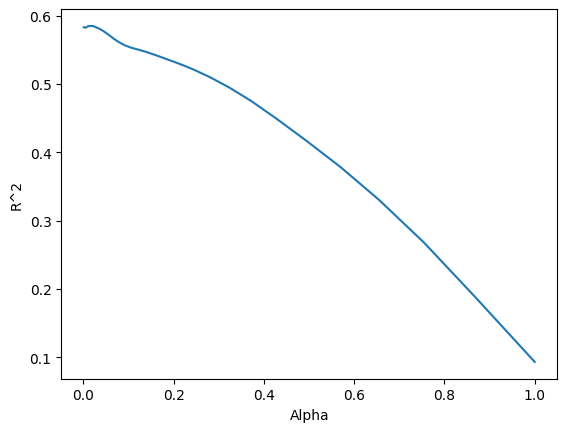

In [28]:
# plotting the best alpha

plt.plot(Alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

In [55]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_poly, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.0019317236601055666
Order 1: avg R^2 = 0.581252301341405
Order 2: avg R^2 = -9.746180144236767


In [56]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)

poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

print(str(poly_train_res) + "\n" + str(poly_val_res))

0.6364276943042018
-1.9699578150766736e+21


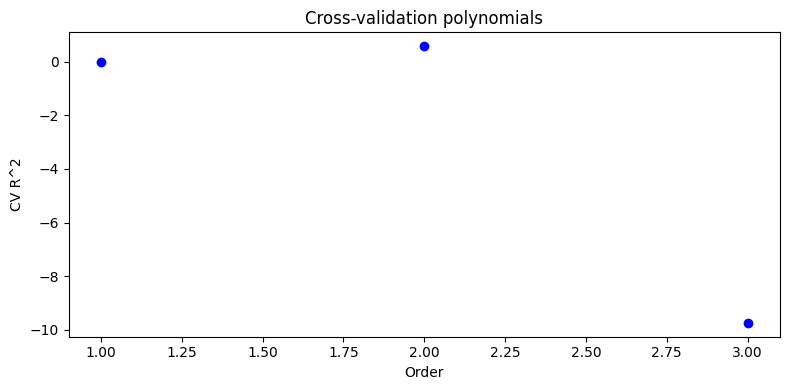

In [57]:
# Plotting the results

fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [58]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 1


In [65]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)

poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

if poly_val_res < 0:
	poly_val_res = 0

print(str(poly_train_res) + "\n" + str(poly_val_res))

0.6364276943042018
0


## 1.2 Model Selection

### 1.2.1 KNN

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)
cv_scores = []
sd_scores = []

for k in K:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

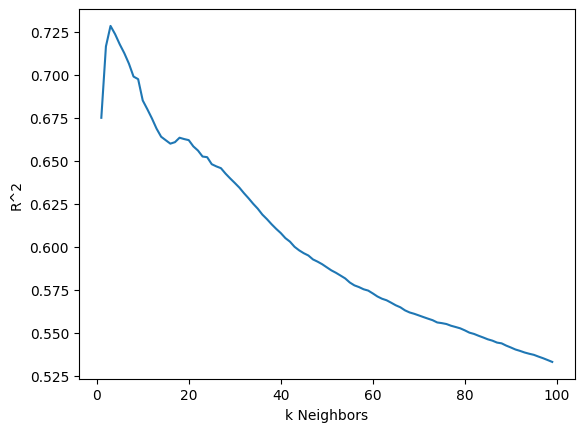

The best k is 3


In [32]:
# Plotting the results

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

In [33]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)

knn_train_res = knn.score(X_train_stand, y_train)
knn_val_res = knn.score(X_val_stand, y_val)

print(str(knn_train_res) + "\n" + str(knn_val_res))

0.8884546496452744
0.7595342835188986


### 1.2.2 Random Forest

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validation
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible

rf_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
93 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

In [35]:
# show the training and validated R^2 for the best model from the random search

best_rf_est = rf_random.best_estimator_

print(best_rf_est.score(X_train_stand, y_train))
print(best_rf_est.score(X_val_stand, y_val))

0.9085664300578373
0.8051753779017239


In [36]:
# retrieve the best parameters of the best model

rf_random.best_params_

{'n_estimators': 216,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 250,
 'max_features': 'sqrt',
 'max_depth': 11,
 'criterion': 'squared_error'}

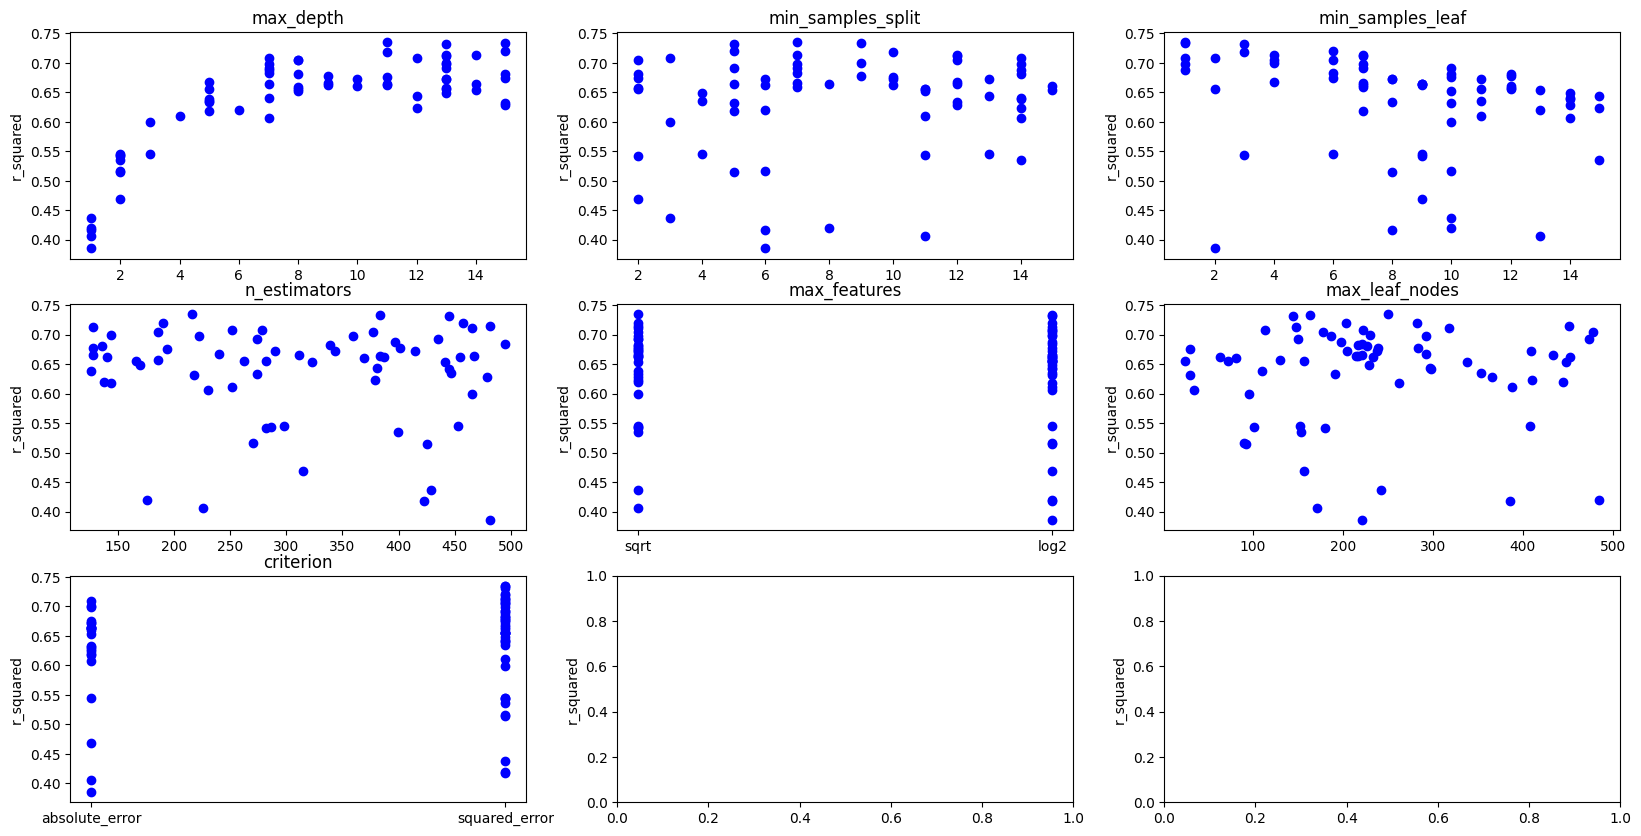

In [37]:
# plotting out the hyperparameters, so we can check which values to use for the grid search. 

out = pd.DataFrame(rf_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')


### 1.2.3 Random Forest - Grid Search

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error']
n_estimators = [225]
max_features = ['sqrt']
max_depth = [13]
min_samples_split = [3]
min_samples_leaf = [1]
max_leaf_nodes = [150]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [13],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [150],
                         'min_samples_leaf': [1], 'min_samples_split': [3],
                         'n_estimators': [225]},
             verbose=2)

In [40]:
# show the training and validated R^2 for the best model from the random search

best_rf_grid_est = rf_grid.best_estimator_

rf_train_res = best_rf_grid_est.score(X_train_stand, y_train)
rf_val_res = best_rf_grid_est.score(X_val_stand, y_val)

print(str(rf_train_res) + "\n" + str(rf_val_res))

0.9365243053951066
0.8029222538553467


In [41]:
# retrieve the best parameters of the best model

rf_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 13,
 'max_features': 'sqrt',
 'max_leaf_nodes': 150,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

## 1.3 White Box Model

In [42]:
# Get the best params

params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)

RandomForestRegressor(max_depth=13, max_features='sqrt', max_leaf_nodes=150,
                      min_samples_split=3, n_estimators=225)

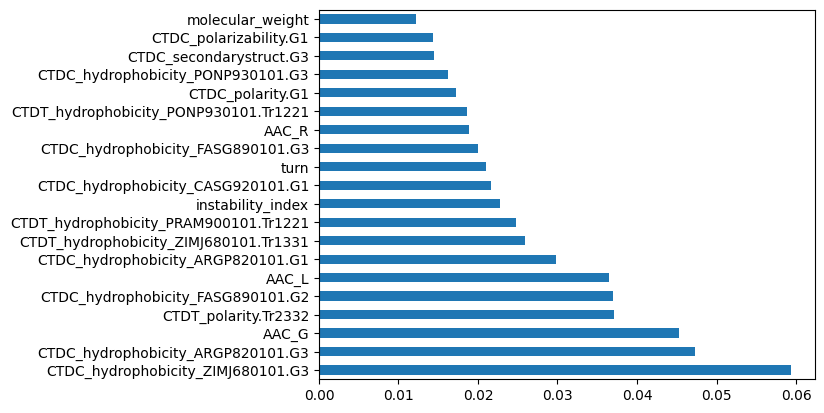

In [43]:
# Plot the 20 most important params

plt.figure()

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### 1.3.1 Influence of certain features

In [44]:
# getting the prediction from the random forest

pred_train = rf_gridBest.predict(X_train_stand)

In [46]:
# Performing one univariate linear regression per feature on the predicted values.

from sklearn.linear_model import LinearRegression

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])
for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)


In [48]:
# Most influential features (positive and negative)

betas.columns = ['Feature','Beta']
betas['abs'] = abs(betas['Beta'])
betas = betas.sort_values(by='abs', ascending=False)
betas = betas.drop(columns='abs')
betas.head(10)

,Feature,Beta
0,AAC_G,0.719326
0,CTDC_hydrophobicity_FASG890101.G2,0.678920
0,AAC_L,-0.668193
0,CTDT_polarity.Tr2332,0.668063
0,CTDT_hydrophobicity_FASG890101.Tr1221,0.664780
0,CTDT_hydrophobicity_PONP930101.Tr1221,0.649225
0,CTDC_polarizability.G1,0.644549
0,CTDC_hydrophobicity_ARGP820101.G1,0.644136
0,CTDC_hydrophobicity_ARGP820101.G3,-0.639318
0,CTDC_hydrophobicity_ZIMJ680101.G3,-0.639312


## 1.4 Gradient Boosting

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

gbm_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
252 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\denis\.virtualenvs\poc-protein-feature

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_node...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [63]:
# Show the validated R^2 for the best model from the random search
best_gbm_rand = gbm_random.best_estimator_

# calculate the training and validation scores of the best estimator
gb_train_res = best_gbm_rand.score(X_train_stand, y_train)
gb_val_res = best_gbm_rand.score(X_val_stand, y_val)

print(str(gb_train_res) + "\n" + str(gb_val_res))

0.9626686353032937
0.7947689280897835


In [51]:
# get the best parameters of the best model
gbm_random.best_params_

{'n_estimators': 410,
 'min_samples_split': 12,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 230,
 'max_features': 'log2',
 'max_depth': 9,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

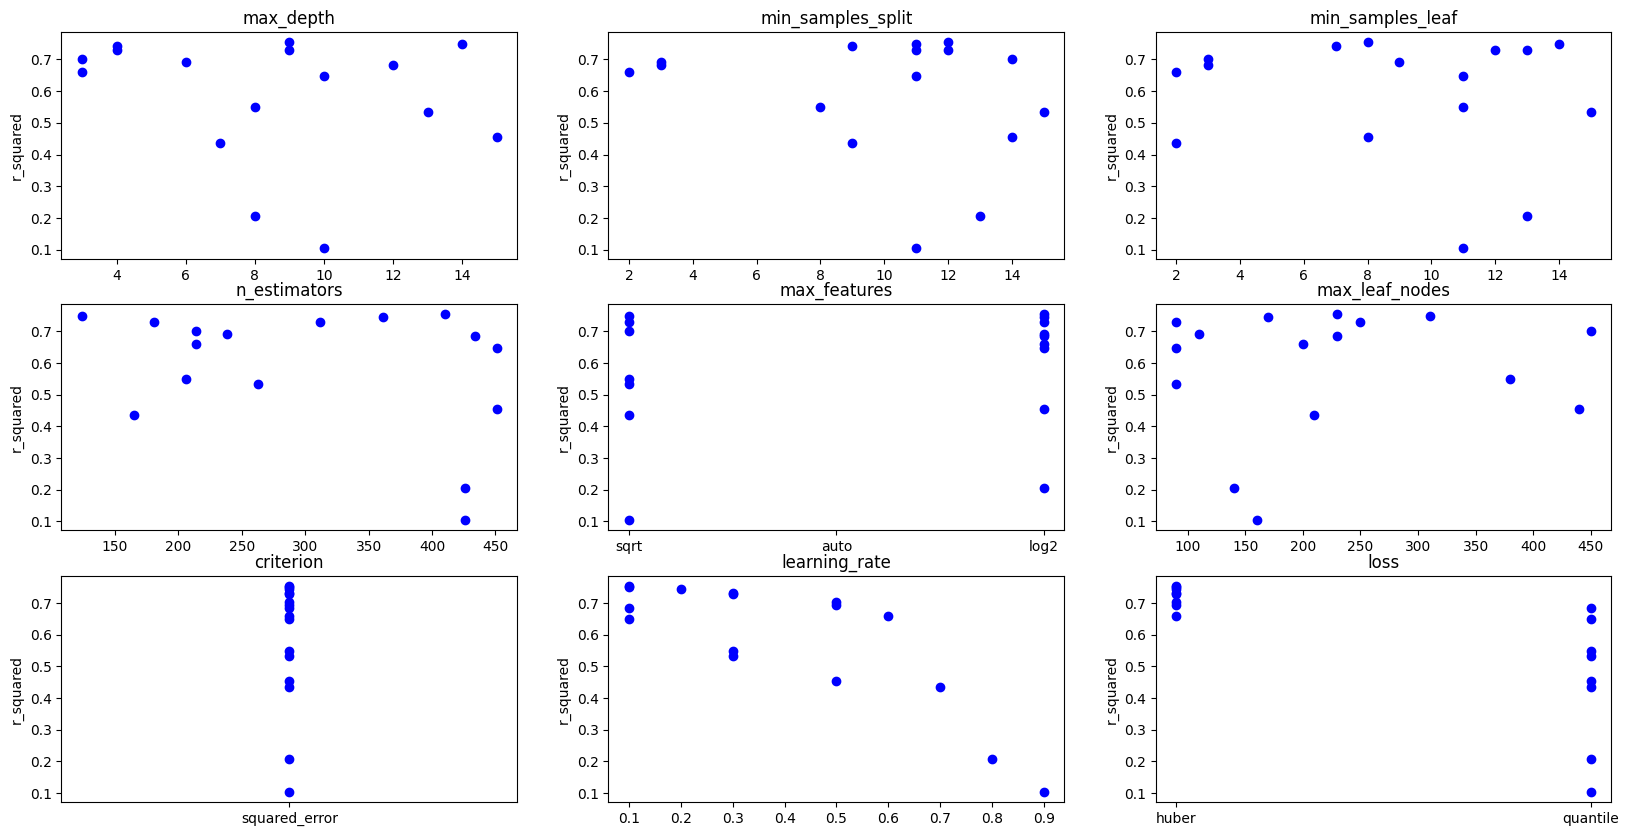

In [52]:
# plotting out the results of the hyperparameters

out = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

axs[2,1].scatter(out['param_learning_rate'], out['mean_test_score'], c='blue')
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out['param_loss'], out['mean_test_score'], c='blue')
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

## 1.5 XGBoost

In [53]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
param_grid = {'criterion': criterion,
			   'n_estimators': n_estimators,
			   'max_features': max_features,
			   'max_depth': max_depth,
			   'min_samples_split': min_samples_split,
			   'min_samples_leaf': min_samples_leaf,
			   'max_leaf_nodes': max_leaf_nodes,
			   'loss': loss,
			   'learning_rate': learning_rate
}

xgb_model = xgb.XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\poc-protein-feature-extraction-1y3QKbqO\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "criterion", "loss", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [62]:
# Show the validated R^2 for the best model from the random search
best_xgb_rand = xgb_random.best_estimator_

# calculate the training and validation scores of the best estimator
xgb_train_res = best_xgb_rand.score(X_train_stand, y_train)
xgb_val_res = best_xgb_rand.score(X_val_stand, y_val)

print(str(xgb_train_res) + "\n" + str(xgb_val_res))

0.9998654790665628
0.7488059359020373


## 1.6 Evaluation

In [67]:
# This code creates a table with the type of model and training and validation data. This is to ensure that each new change the evaluation is updated automatically.

from IPython.display import Markdown as md

table_template = "|Model|Train|Validation|\n| --- | --- | --- |\n|PolynomialRegressor|{poly_train:.1%}|{poly_val:.1%}|\n|KNearestNeighbor|{knn_train:.1%}|{knn_val:.1%}|\n|RandomForestRegressor|{rf_train:.1%}|{rf_val:.1%}|\n|GradientBoostingRegressor|{gb_train:.1%}|{gb_val:.1%}|\n|XGradientBoostingRegressor|{xgb_train:.1%}|{xgb_val:.1%}|"


md(table_template.format(poly_train=poly_train_res, poly_val=poly_val_res, knn_train=knn_train_res, knn_val=knn_val_res, rf_train=rf_train_res, rf_val=rf_val_res, gb_train=gb_train_res, gb_val=gb_val_res, xgb_train=xgb_train_res, xgb_val=xgb_val_res))

|Model|Train|Validation|
| --- | --- | --- |
|PolynomialRegressor|63.6%|0.0%|
|KNearestNeighbor|88.8%|76.0%|
|RandomForestRegressor|93.7%|80.3%|
|GradientBoostingRegressor|96.3%|79.5%|
|XGradientBoostingRegressor|100.0%|74.9%|

The validation set will be used to evaluate the model. Gradient Boosting will be used to predict the test dataset, even though the Random Forest model has a higher validation accuracy.

In [70]:
# use the GradientBoostingRegressor to predict the test set
gbm_pred = best_gbm_rand.predict(X_test_stand)

# show the accuracy of the model
gbm_test_res = best_gbm_rand.score(X_test_stand, y_test)
print(gbm_test_res)

0.771836873563526


Mean Absolute Error (MAE): 0.4888519997438183
Mean Squared Error (MSE): 0.6571888584335631
Root Mean Squared Error (RMSE): 0.8106718561992659
R-squared (R2) Score: 0.771836873563526


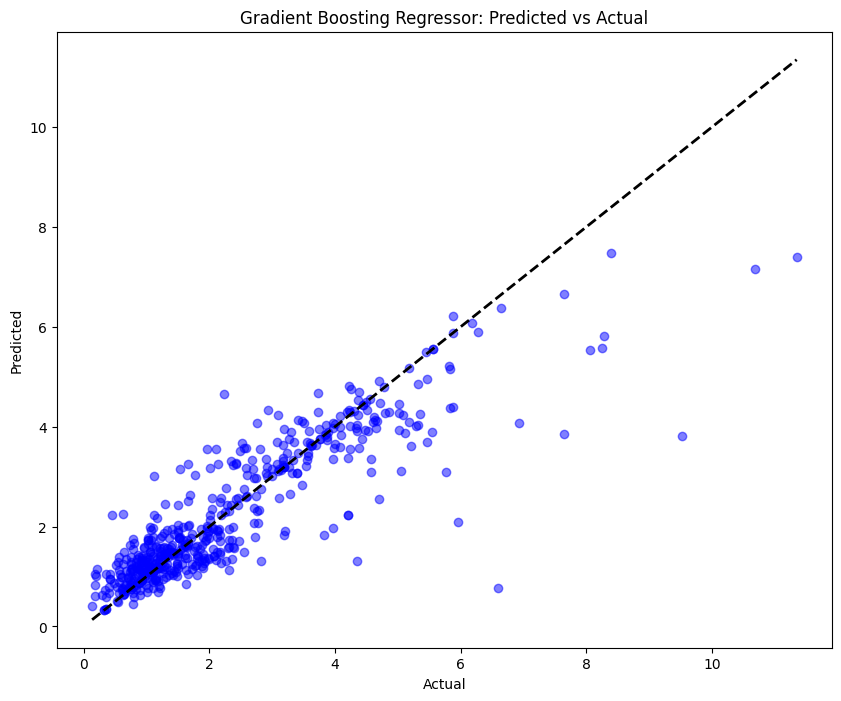

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, gbm_pred)
mse = mean_squared_error(y_test, gbm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, gbm_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

# Plot predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, gbm_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', lw=2)
plt.title('Gradient Boosting Regressor: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

## 1.7 Conclusion

- `Mean Absolute Error (MAE)`: The average absolute difference between the predicted and actual values is approximately 0.489. This means, on average, the model's predictions are off by about 0.489 units.

- `Mean Squared Error (MSE)`: The average squared difference between the predicted and actual values is approximately 0.657. This metric penalizes larger errors more heavily than MAE.

- `Root Mean Squared Error (RMSE)`: The square root of MSE is approximately 0.811. RMSE is interpreted in the same units as the target variable and provides a measure of the spread of errors.

- `R-squared (R^2) Score`: The R-squared value of approximately 0.772 indicates that the model explains about 77.2% of the variance in the target variable. In other words, the model captures around 77.2% of the variability in the data, which is considered a moderately good fit.

**Based on these values:**

- The MAE, MSE, and RMSE indicate that, on average, the model's predictions are off by around 0.489 units. The RMSE of 0.811 suggests that the model's predictions have some spread around the actual values.

- The R-squared score of 0.772 suggests that the model explains a substantial portion of the variance in the target variable, indicating a reasonably good fit.

The project aimed to predict the 'Kcat' feature, a kinetic parameter generated from the UniKP framework, using multiple regression models including K Nearest Neighbor (KNN), XGBoost (XGB), Gradient Boosting (GB), Random Forest, and Polynomial Regression. The dataset was created using a Fondant pipeline that generated multiple features before feeding them into the regression models.

After training and evaluating the models, it was found that the Gradient Boosting Regressor performed the best, achieving a training accuracy of 96.3% and a validation accuracy of 79.5%. Additionally, the Random Forest Regressor also showed promising performance, with a training accuracy of 93.7% and a validation accuracy of 80.3%. These models demonstrated the ability to generalize well to unseen data, as indicated by the relatively high validation accuracies.

Further analysis revealed that the Gradient Boosting Regressor had a Mean Absolute Error (MAE) of 0.489, a Mean Squared Error (MSE) of 0.657, a Root Mean Squared Error (RMSE) of 0.811, and an R-squared (R2) Score of 0.772. These metrics suggest that the model's predictions are, on average, off by approximately 0.489 units, and it explains about 77.2% of the variance in the target variable.

In conclusion, the Gradient Boosting Regressor and Random Forest Regressor are recommended for predicting the 'Kcat' feature due to their strong performance and ability to generalize well to new data. However, further refinement and optimization of the models may be beneficial to improve prediction accuracy even further.
